# Notebook for the generation of visualizations used in the paper.

In [5]:
import pandas as pd
import config as cfg

results = pd.read_csv('/Users/alan.paredes/Desktop/confetti/benchmark/evaluations/all_evaluation_results.csv')
column_order = ['Explainer', 'Model', 'Dataset', 'Alpha', 'Param Config', 'Coverage', 'Validity', 'Confidence',
                    'Sparsity', 'Proximity L1', 'Proximity L2', 'Proximity DTW', 'yNN']
results = results[column_order]

## Figure 2. Example of CONFETTI’s CE generation for MTS.

After a close evaluation of results, we decided that for the purpose of Figure 2, we will use the results of Confetti Optimized with $\theta=0.85$ and $\alpha=0.5$ for the BasicMotions dataset.

In [6]:
from confetti.explainer.utils import load_data, load_multivariate_ts_from_csv, convert_string_to_array
from confetti.CAM import compute_weights_cam
import keras
from visualizer import plot_with_cam

In [7]:
# Load model
model = keras.models.load_model('/Users/alan.paredes/Desktop/confetti/models/trained_models/BasicMotions/BasicMotions_fcn.keras')

# Load training dataset
X_train, X_test, y_train, y_test = load_data("BasicMotions", one_hot=False)

#Get results
basic_motions_confetti_fcn = pd.read_csv('/Users/alan.paredes/Desktop/confetti/results/BasicMotions/confetti_optimized_BasicMotions_fcn_theta_0.85.csv')
basic_motions_confetti_fcn['Solution'] = basic_motions_confetti_fcn['Solution'].apply(
    lambda x: convert_string_to_array(x, timesteps=100, channels=6)
)

#Compute training weights
weights = compute_weights_cam(model=model, X_data=X_train, dataset="BasicMotions",
                                                   save_weights=False, data_type='training')

#load samples
sample_file = f"{cfg.DATA_DIR}/{"BasicMotions"}_fcn_samples.csv"
X_samples, y_samples = load_multivariate_ts_from_csv(sample_file)

In [8]:
basic_motions_confetti_fcn.iloc[2]

Solution         [[-0.740653, -0.740653, 10.208449, 2.867009, -...
Window                                                          16
Test Instance                                                    0
NUN Instance                                                    27
CE Label                                                         3
Name: 2, dtype: object

In [9]:
sample = X_samples[0]
counterfactual = basic_motions_confetti_fcn.iloc[2]['Solution']
nun_weight = weights[27] # Counterfactual for sample 0 used NUN 27

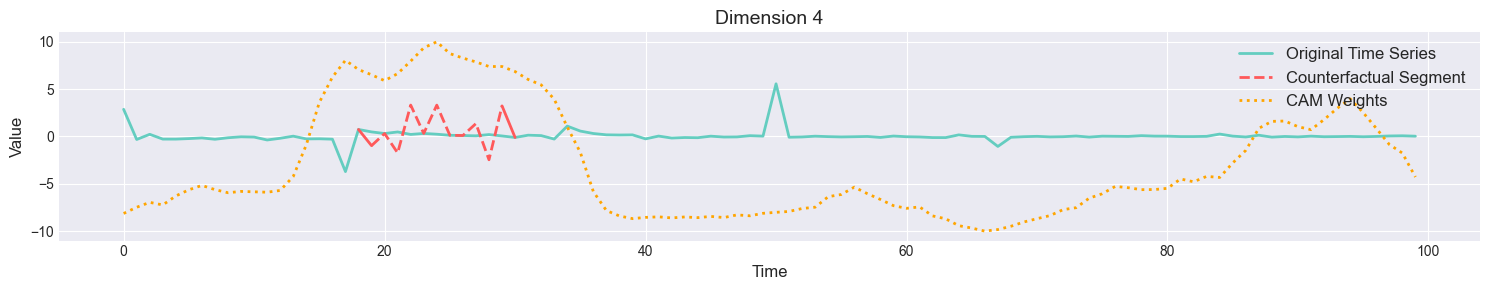

,Original_Dim_4,Counterfactual_Dim_4,CAM_Weights
0,2.867009,2.867009,-8.134952
1,-0.319864,-0.319864,-7.480880
2,0.227270,0.227270,-6.961388
3,-0.279022,-0.279022,-7.234788
4,-0.280422,-0.280422,-6.286893
...,...,...,...
95,-0.031960,-0.031960,2.513736
96,0.002663,0.002663,0.857406
97,0.053267,0.053267,-0.849643
98,0.071911,0.071911,-1.752861


In [10]:
plot_with_cam(sample, counterfactual, nun_weight, dimension=3)

## Figure 3. Diverse CEs generated by CONFETTI for a single instance from the BasicMotions dataset

For the purpose of Figure 3, we will use the results of Confetti Optimized with $\alpha=0.0$ and $\alpha=1.0$ for the BasicMotions dataset. Specifically, we will select the first counterfactual from each of the two configurations. (Instance 0, used NUN 27)

In [11]:
from visualizer import compare_counterfactuals

In [12]:
results_confidence = pd.read_csv('/Users/alan.paredes/Desktop/confetti/results/BasicMotions/confetti_optimized_BasicMotions_fcn_alpha_1.0.csv')
results_sparsity = pd.read_csv('/Users/alan.paredes/Desktop/confetti/results/BasicMotions/confetti_optimized_BasicMotions_fcn_alpha_0.0.csv')

#For reference, we will also plot the naive counterfactual
# It is worth to mention that no matter the value of alpha, the naive counterfactual is always the same.
results_naive = pd.read_csv('/Users/alan.paredes/Desktop/confetti/results/BasicMotions/confetti_naive_BasicMotions_fcn_alpha_0.0.csv')

# Convert the 'Solution' column from string to numpy array
results_confidence['Solution'] = results_confidence['Solution'].apply(
    lambda x: convert_string_to_array(x, timesteps=100, channels=6)
)
results_sparsity['Solution'] = results_sparsity['Solution'].apply(
    lambda x: convert_string_to_array(x, timesteps=100, channels=6)
)
results_naive['Solution'] = results_naive['Solution'].apply(
    lambda x: convert_string_to_array(x, timesteps=100, channels=6)
)

counterfactual_naive = results_naive.iloc[0]['Solution']
counterfactual_confidence = results_confidence.iloc[0]['Solution']
counterfactual_sparsity = results_sparsity.iloc[0]['Solution']

counterfactual_list = [counterfactual_naive, counterfactual_confidence, counterfactual_sparsity]

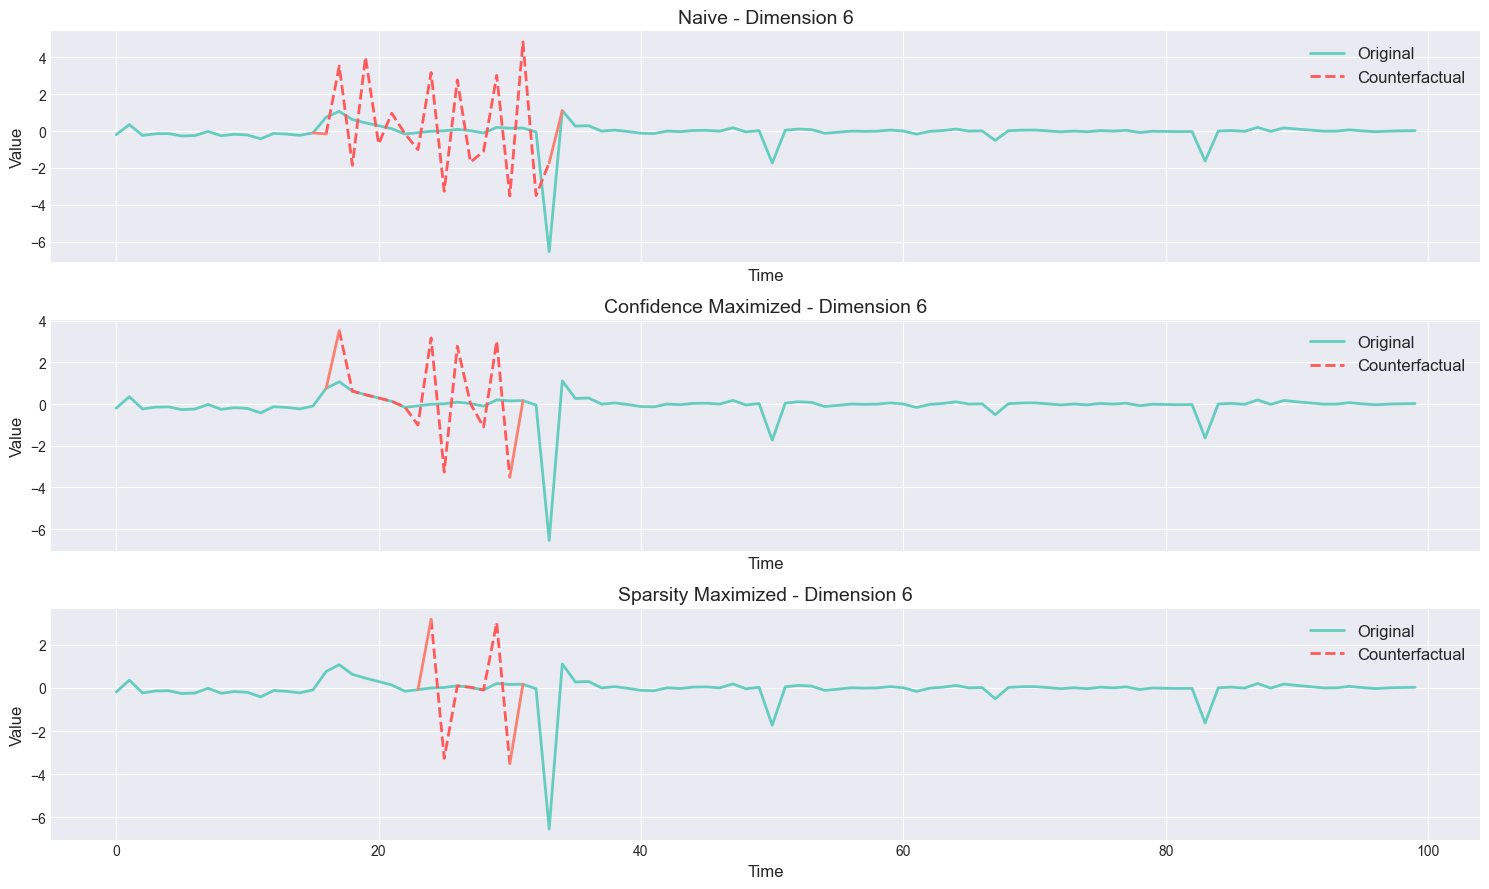

In [13]:
compare_counterfactuals(sample, counterfactual_list, dimension=5, titles=["Naive","Confidence Maximized", "Sparsity Maximized"])

## Figure N. Trade-offs

In [14]:
# Obtain all the rows where the Explainer contains somehow 'confetti'
confetti_results = results[results['Explainer'].str.contains('Confetti Optimized', case=False, na=False)]
results_alphas = confetti_results[confetti_results['Alpha'] == True]
results_thetas = confetti_results[confetti_results['Alpha'] == False]

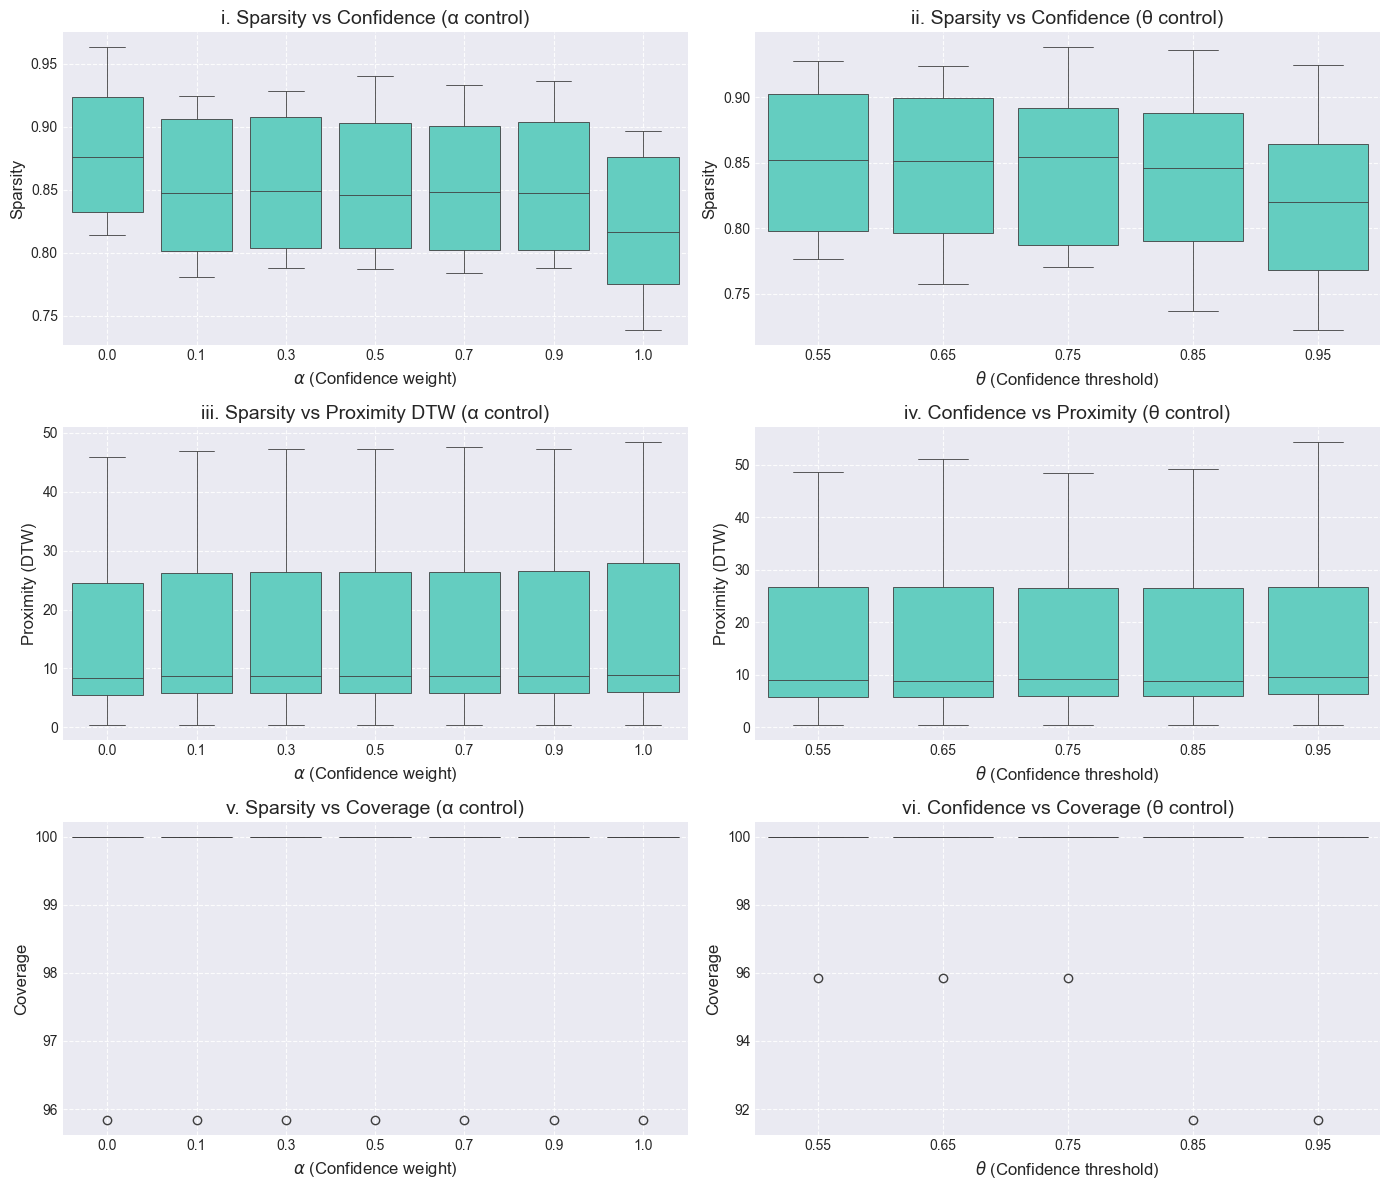

In [15]:
from visualizer import boxplot_all_tradeoffs
boxplot_all_tradeoffs(results_alphas, results_thetas)

## Figure N. How parameters affect execution times.

In [16]:
execution_times = pd.read_csv('/Users/alan.paredes/Desktop/confetti/results/execution_times_confetti_fcn.csv')

In [17]:
execution_times_alpha = execution_times.groupby(['Dataset', 'Alpha']).agg({"Execution Time": "mean"}).reset_index()
execution_times_theta = execution_times.groupby(['Dataset', 'Theta']).agg({"Execution Time": "mean"}).reset_index()

In [18]:
execution_times_alpha

,Dataset,Alpha,Execution Time
0,ArticularyWordRecognition,0.0,192.962066
1,ArticularyWordRecognition,0.1,234.324769
2,ArticularyWordRecognition,0.3,220.076983
3,ArticularyWordRecognition,0.5,242.505424
4,ArticularyWordRecognition,0.7,224.365789
5,ArticularyWordRecognition,0.9,225.124844
6,ArticularyWordRecognition,1.0,234.616086
7,BasicMotions,0.0,315.466074
8,BasicMotions,0.1,313.195411
9,BasicMotions,0.3,311.977776


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_execution_times_by_param(results: pd.DataFrame) -> None:
    """
    Plots execution times by alpha or theta parameter across datasets using independent y-axis scales.

    Assumes `results` is a preprocessed DataFrame with columns:
    - Dataset
    - Alpha or Theta
    - Execution Time

    Parameters:
    - results (pd.DataFrame): Preprocessed execution times.
    """
    sns.set(style="darkgrid")

    if "Alpha" in results.columns:
        param_col = "Alpha"
        xlabel = r"$\alpha$"
        title_prefix = "Execution Time by Alpha"
    elif "Theta" in results.columns:
        param_col = "Theta"
        xlabel = r"$\theta$"
        title_prefix = "Execution Time by Theta"
    else:
        raise ValueError("The DataFrame must contain either 'Alpha' or 'Theta' column.")

    g = sns.catplot(
        data=results,
        x=param_col,
        y="Execution Time",
        col="Dataset",
        kind="bar",
        sharey=False,
        height=4,
        aspect=1.2,
        palette=["#64cdc0"],
    )

    g.set_titles("{col_name}")
    g.set_axis_labels(xlabel, "Execution Time (s)")
    plt.suptitle(title_prefix, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()


/var/folders/4p/h1lv5qps7fjb7sjbt5t67w6wkt06gc/T/ipykernel_4805/964480345.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/4p/h1lv5qps7fjb7sjbt5t67w6wkt06gc/T/ipykernel_4805/964480345.py:30: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


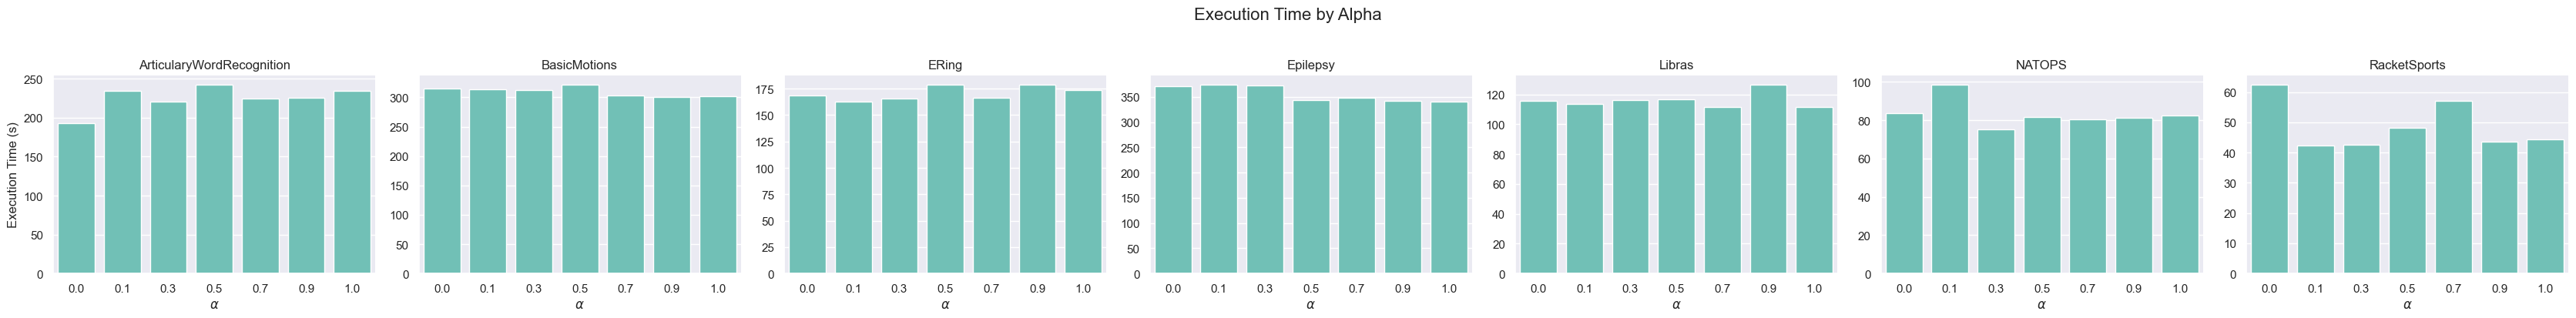

In [20]:
plot_execution_times_by_param(execution_times_alpha)

/var/folders/4p/h1lv5qps7fjb7sjbt5t67w6wkt06gc/T/ipykernel_4805/964480345.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/4p/h1lv5qps7fjb7sjbt5t67w6wkt06gc/T/ipykernel_4805/964480345.py:30: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


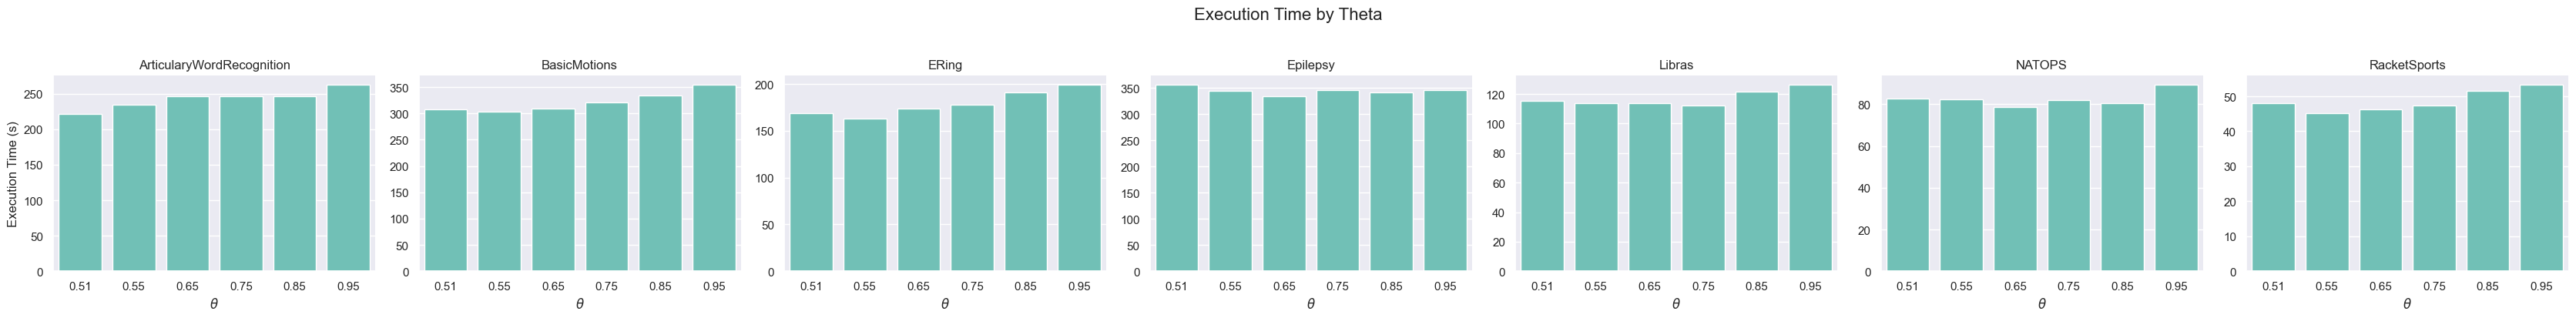

In [21]:
plot_execution_times_by_param(execution_times_theta)